In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from importlib import reload

import xarray as xr
import xnemogcm as xn
import xgcm

from pyCDFTOOLS import analysis, in_out
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# try opening
base_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"  # mesh_mask lives here
data_dir = base_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/"

domcfg = xn.open_domain_cfg(base_dir)

# opening file already in _grid_T.nc convention; going to load everything into one object
ds = xn.open_nemo_and_domain_cfg(
    domcfg_files=base_dir,
    nemo_files=[data_dir + "UNAGI_10y_08010101_08101230_grid_T.nc",
                data_dir + "UNAGI_10y_08010101_08101230_grid_U.nc",
                data_dir + "UNAGI_10y_08010101_08101230_grid_V.nc"]
)

# open files not in the _grid_T.nc convention (note domcfg goes AFTER positions here)
ds_1y = xn.process_nemo(
    positions=[
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_T.nc"), 'T'),
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_U.nc"), 'U'),
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_V.nc"), 'V'),
    ],
    domcfg=domcfg,
)

# could merge into one if you want (depends if you want multiple objects floating around)
# warning: if "t_bound" clash, then at risk of the ds data variables being killed (NaNs)
# ds = ds.merge(ds_1y, compat="override")
# del ds_1  # free up the object

In [3]:
# generate the grid object

Static_e3 = True
metrics_dict = xn.get_metrics(ds)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values
    
# either 1) let xgcm figure out the positions
# coords = None

# or 2) specify it (below should be right for NEMO convention; things are shifted to the RIGHT)
coords = {"X": {"right": "x_f", "center":"x_c"},  # xU > xT
          "Y": {"right": "y_f", "center":"y_c"},  # yV > yT
          "Z": {"center": "z_c", "left": "z_f"},  # zW < zT !!! (?)
          "T": {"center": "t"},
          }

# NOTE: some of the subroutines will modify the specification accordingly (e.g. z co-ord transforms)

# specify periodicity with a list
grid = xgcm.Grid(ds, coords=coords, metrics=metrics_dict, periodic=["X"])

bd = {'boundary':'fill', 'fill_value':0}

### cdfcurl (vorticity)

=== WARNING: no z_c information found, assume it is a T-grid variable ===


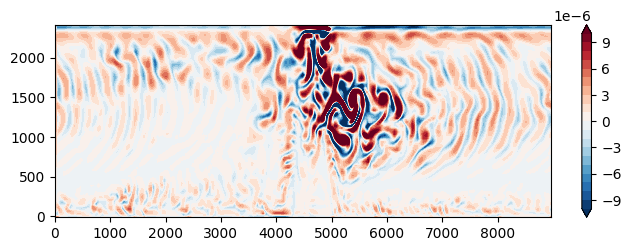

In [4]:
# reload(analysis)

# there are NaN's in the data for some reason...? 
# pass data per time frame (in line with t_bound in ds; ugly, to tidy)
xi = analysis.cdfcurl(grid, ds, ds_1y.ssu_inst.isel(t=2), ds_1y.ssv_inst.isel(t=2), **bd)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(xi.glamf[:, :-1], xi.gphif[:, :-1], xi[:, :-1],
                 levels=np.linspace(-1e-5, 1e-5, 21), cmap="RdBu_r", extend="both")
plt.colorbar(cs)

In [5]:
# test write of data (promote to dataset first)
# in_out.save_netcdf(xi)

## cdfmoc (averaging at fixed depth)

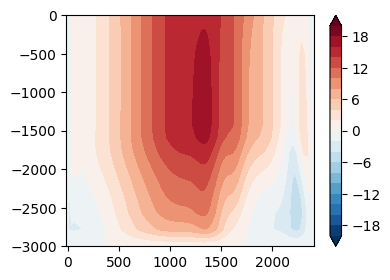

In [6]:
reload(analysis)

moc = analysis.cdfmoc(grid, ds, ds.voce.isel(t=0), **bd)

# problem near the periodic boundary outputs at 0 and -1, just don't use it for now...
# great big deep reaching (unphysical) Deacon cell, as expected

fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
cs = ax.contourf(moc.gphiv, -moc.gdepw_1d, moc,
                 levels=np.linspace(-20, 20, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

## cdfzonalmean (along i-direction)

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, '$\\overline{v}$')

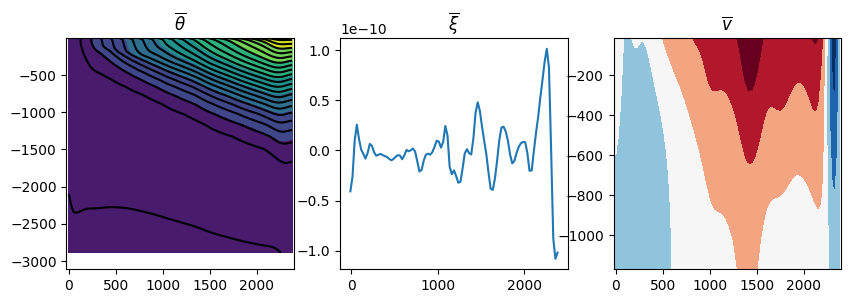

In [7]:
reload(analysis)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

dum = analysis.cdfzonalmean(grid, ds, ds.toce, **bd)
axs[0].contourf(dum.gphit, -dum.gdept_1d, dum.isel(t=0))
axs[0].contour(dum.gphit, -dum.gdept_1d, dum.isel(t=0), 20, colors='k')
axs[0].set_title(r"$\overline{\theta}$")

dum = analysis.cdfzonalmean(grid, ds, xi, **bd)
axs[1].plot(dum.gphif, dum)
axs[1].set_title(r"$\overline{\xi}$")

dum = analysis.cdfzonalmean(grid, ds, ds.uoce[:, 1:20, :, :], **bd)
axs[2].contourf(dum.gphiu, -dum.gdept_1d, dum.isel(t=0), cmap="RdBu_r", extend="both")
axs[2].set_title(r"$\overline{v}$")


## cdfz2sig (vertical co-ordinate transformation)

Useful subroutine probably, intermediary for doing averaging in density co-ordinates (e.g. `cdfmocsig`).
Can in principle do any co-ordinate transformation (e.g. z -> z).

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


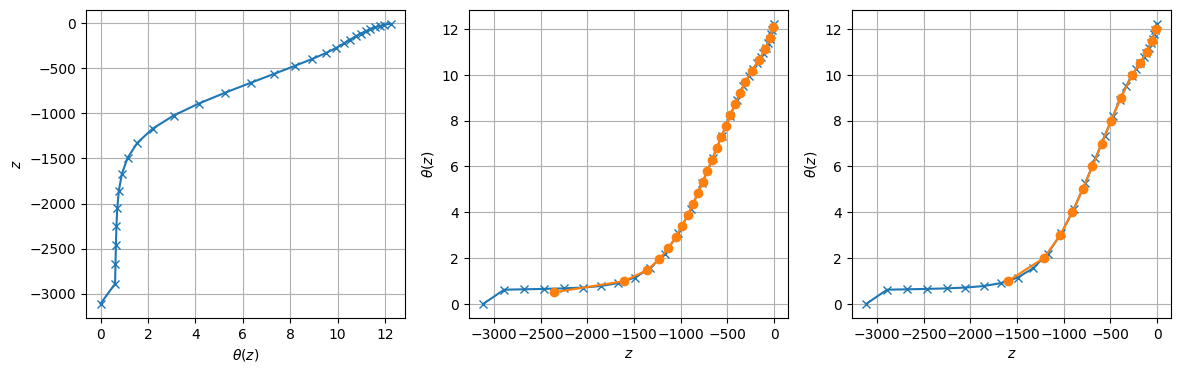

In [8]:
# demonstrating the use of xgcm.transform in the vertical co-ordinate first

# linear and log interp, only from z -> sigma (sigma is just a placeholder)

reload(analysis)

theta = ds.toce[0, :, 80, 40]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].plot(theta, -theta.gdept_1d, 'C0-x')
axs[0].set_xlabel(r"$\theta(z)$")
axs[0].set_ylabel(r"$z$")
axs[0].grid()

theta_coord = np.linspace(0.5, 15, 31)
z_sigma = analysis.cdfz2sig(ds, -theta.gdept_1d, theta, theta_coord, **bd)

axs[1].plot(-theta.gdept_1d, theta, 'C0-x')
axs[1].plot(z_sigma, z_sigma.sigma, 'C1-o')
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\theta(z)$")
axs[1].grid()

# artificially stretched coordinate
theta_coord = np.asarray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                          10.5, 11.0, 11.5, 12.0, 12.25, 12.50, 12.75, 13.0,
                          13.2, 13.4, 13.6, 13.8, 14.0,
                          14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0])
z_sigma = analysis.cdfz2sig(ds, -theta.gdept_1d, theta, theta_coord, method="log", **bd)

axs[2].plot(-theta.gdept_1d, theta, 'C0-x')
axs[2].plot(z_sigma, z_sigma.sigma, 'C1-o')
axs[2].set_xlabel(r"$z$")
axs[2].set_ylabel(r"$\theta(z)$")
axs[2].grid()

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:172: RuntimeWarning: divide by zero encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:172: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


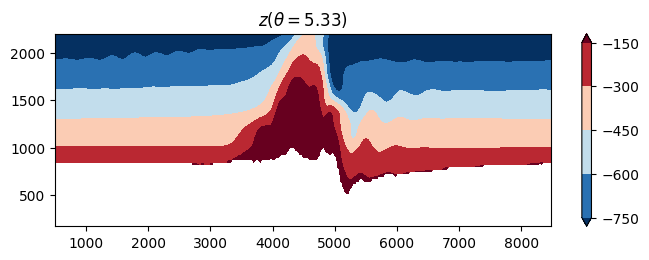

In [9]:
# project the height field onto a sigma surface

theta = ds.toce[0, :, 8:90, 20:340]  # chunk this for the hell of it
theta_coord = np.linspace(0.5, 15, 31)

# promote gdept_1d from 1d to 3d by multiplying the mask
z_sigma = analysis.cdfz2sig(ds, -theta.gdept_1d * ds.tmask[:, 8:90, 20:340], theta, theta_coord, **bd)
    
# plotting quantity on an theta surface
sigma_ind = 10

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(z_sigma.glamt, z_sigma.gphit, 
                 z_sigma[sigma_ind], cmap="RdBu_r", extend="both")
ax.set_title(r"$z(\theta = %.2f)$" % z_sigma.sigma[sigma_ind].values)
plt.colorbar(cs)

In [10]:
# random point above that is displayed as nan, and check there are in fact no valid values
# should return as True
all(theta[20, 70].values < z_sigma.sigma[sigma_ind].values)

True

In [11]:
# need an "outer" axis here for z (ASSUME here for now we are not dealing with W-grid variables)
# coords = {"X": {"right": "x_f", "center":"x_c"},  # xU > xT
#           "Y": {"right": "y_f", "center":"y_c"},  # yV > yT
#           "Z": {"center": "z_c", "outer": "z_f"},  # zW < zT !!! (?)
#           "T": {"center": "t"},
#           }
# grid = xgcm.Grid(ds, coords=coords, metrics=metrics_dict, periodic=False)

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Text(0.5, 1.0, '$\\int v\\; {\\rm d}\\theta = \\sum v \\Delta z = 26.81938718$')

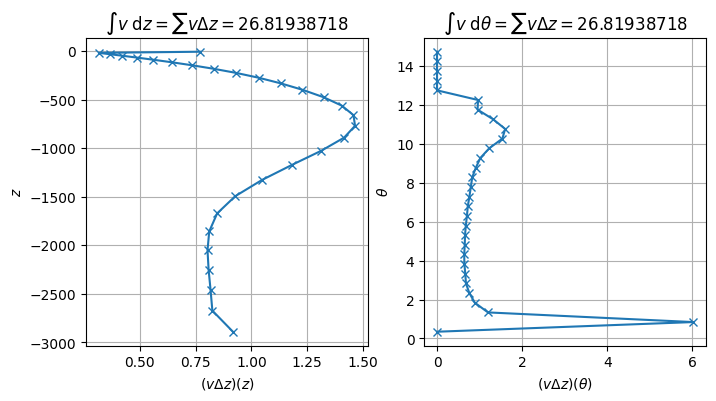

In [14]:
# conservative transformation (integral is preserved)
# only strictly valid for extensive quantities like transport (because the input has grid factors)

theta = grid.interp(ds.toce[0, :, :, :], ['Y'], boundary='extend')
theta_coord = np.linspace(0.1, 15, 31)

# don't select the last one since it's land, then z_f makes sense
v_trans = (ds.voce * ds.e3v_0 * ds.vmask)[0, slice(0, -1), :, :]
v_trans = v_trans.fillna(0.).rename('v_trans')

v_trans_sigma = analysis.cdfz2sig(ds,                             # metrics
                                  v_trans,                        # input 
                                  theta.isel(z_c=slice(0, -1)),   # to be consistent with dims of input
                                  theta_coord,                    # new coords
                                  method="conservative", **bd)

j_ind, i_ind = 80, 40

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(v_trans[:, j_ind, i_ind], -v_trans.gdept_1d, 'C0-x')
axs[0].set_xlabel(r"$(v\Delta z)(z)$")
axs[0].set_ylabel(r"$z$")
axs[0].grid()
axs[0].set_title(r"$\int v\; {\rm d}z = \sum v \Delta z = %.8f$" 
                 % v_trans[:, j_ind, i_ind].sum("z_c").values)

axs[1].plot(v_trans_sigma[:, j_ind, i_ind], v_trans_sigma.sigma, 'C0-x')
axs[1].set_xlabel(r"$(v\Delta z)(\theta)$")
axs[1].set_ylabel(r"$\theta$")
axs[1].grid()
axs[1].set_title(r"$\int v\; {\rm d}\theta = \sum v \Delta z = %.8f$" 
                 % v_trans_sigma[:, j_ind, i_ind].sum("sigma").values)

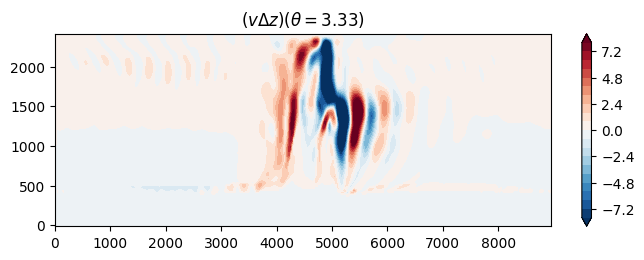

In [15]:
# plotting quantity on an sigma surface

sigma_ind = 6

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(v_trans_sigma.glamv[:, :-1], v_trans_sigma.gphiv[:, :-1], 
                 v_trans_sigma[sigma_ind, :, :-1],
                 levels=np.linspace(-8, 8, 21), cmap="RdBu_r", extend="both")
ax.set_title(r"$(v\Delta z)(\theta = %.2f)$" % v_trans_sigma.sigma[sigma_ind].values)
plt.colorbar(cs)


## cdfmocsig (averaging in density co-ordinates)

Expects the thickness weighted velocity (i.e. `v * e3v`, a transport, possibly with a factor of `e1v`), which is then transformed into density space conservatively.